# Germinal center replay modeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ete3

from gcdyn import bdms, gpmap, mutators, poisson, utils
from experiments import replay

/opt/miniconda3/envs/gcdyn/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
/opt/miniconda3/envs/gcdyn/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


## Parameters

Genotype-phenotype map based on additive DMS binding effects

In [2]:
dms = replay.dms()
gp_map = gpmap.AdditiveGPMap(dms["affinity"], nonsense_phenotype=dms["affinity"].min().min())
assert gp_map(replay.NAIVE_SEQUENCE) == 0

Response functions

In [3]:
birth_response = poisson.SigmoidResponse(xscale=1.0, xshift=1.0, yscale=5.0, yshift=0.1)
# birth_response = poisson.ConstantResponse(1.0)
death_response = poisson.ConstantResponse(1.0)
mutation_response = poisson.SequenceContextMutationResponse(replay.mutability(), mutation_intensity=1.0)

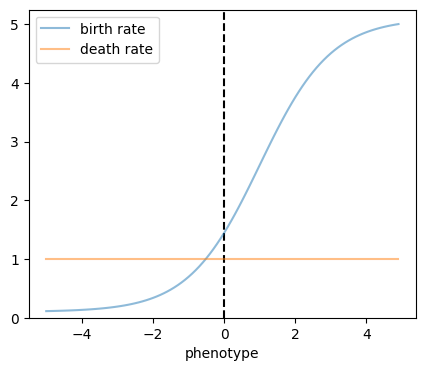

In [4]:
x_grid = np.arange(-5, 5, 0.1)

plt.figure(figsize=(5, 4))
plt.axvline(0, color="k", linestyle="--")
plt.plot(x_grid, birth_response.λ_phenotype(x_grid), label="birth rate", alpha=0.5)
plt.plot(x_grid, death_response.λ_phenotype(x_grid), label="death rate", alpha=0.5)
plt.xlabel('phenotype')
plt.ylim(0, None)
plt.legend()
plt.show()

Mutator

In [5]:
mutator = mutators.SequencePhenotypeMutator(mutators.ContextMutator(mutability=replay.mutability(),
                                                                    substitution=replay.substitution()),
                                            gp_map)

## Simulate

Initialize tree root

In [6]:
tree = bdms.TreeNode()
tree.x = gp_map(replay.NAIVE_SEQUENCE)
tree.sequence = replay.NAIVE_SEQUENCE
tree.sequence_context = replay.seq_to_contexts(replay.NAIVE_SEQUENCE)

Random seed

In [7]:
rng = np.random.default_rng(seed=0)

Parameters

In [8]:
time = 20
capacity = 100

In [9]:
tree.evolve(
    time,
    birth_response,
    death_response,
    mutation_response,
    mutator,
    capacity=capacity,
    init_population=10,
    min_survivors=50,
    capacity_method="death",
    birth_mutations=False,
    seed=rng,
    verbose=False,
)

print(f"tip count: {len(tree)}")

tip count: 3710


Check that node sequences and sequence contexts are consistent

In [10]:
for node in tree.traverse():
    for a, b in zip(replay.seq_to_contexts(node.sequence), node.sequence_context):
        assert a == b

Check that node times and branch lengths are consistent

In [11]:
for node in tree.iter_descendants():
    assert np.isclose(node.t - node.up.t, node.dist)

In [12]:
tree.ladderize()

3710

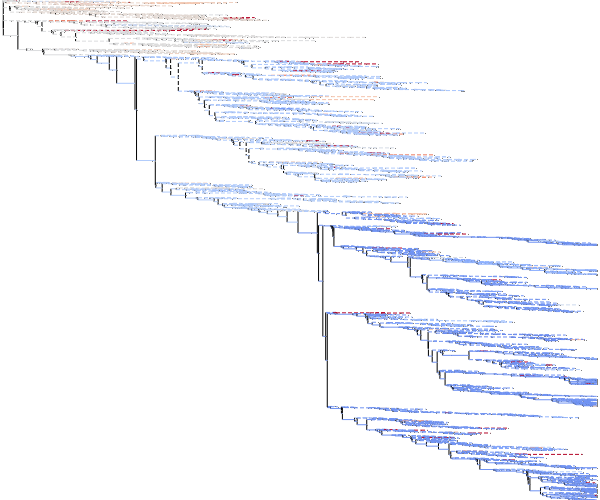

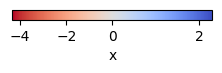

In [13]:
tree.render("x", "%%inline", w=600, h=500)

Population size history

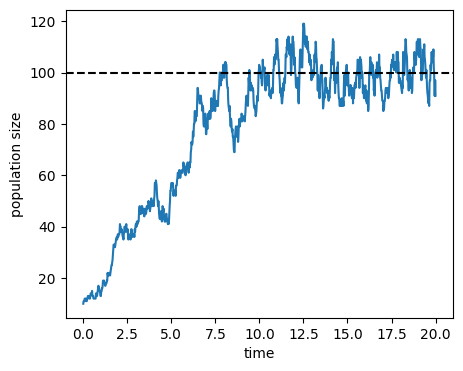

In [14]:
t_grid = np.linspace(0.001, time, 1000)
n_t = [len(tree.slice(t)) for t in t_grid]
plt.figure(figsize=(5, 4))
plt.plot(t_grid, n_t)
plt.axhline(capacity, color="k", linestyle="--")
plt.xlabel("time")
plt.ylabel("population size")
plt.show()

Sample survivors

In [15]:
tree.sample_survivors(n=50, seed=rng)

Prune extinct or unobserved subtrees

In [16]:
tree.prune()
tree.ladderize()

50

Mean affinity of sampled cells

In [17]:
np.mean([leaf.x for leaf in tree])

1.3742842000000002

Render the pruned tree

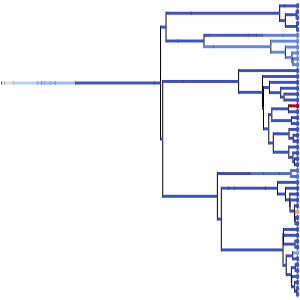

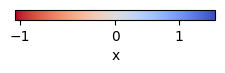

In [18]:
ts = ete3.TreeStyle()
ts.branch_vertical_margin = 1.0
ts.show_leaf_name = False
ts.show_scale = False

tree.render("x", "%%inline", h=300, w=300, tree_style=ts)

Remove unifurcating mutation event nodes and render

In [19]:
tree.remove_mutation_events()

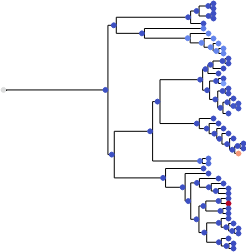

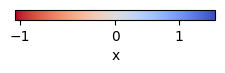

In [20]:
def layout(node):
    node.img_style["size"] = 5

tree.render("x", "%%inline", layout)

Optionally write out tree and sequences

In [21]:
if False:
    with open("tree.nwk", "w") as f:
        f.write(tree.write()+"\n")

    utils.write_leaf_sequences_to_fasta(tree, "seqs.fasta", naive=replay.NAIVE_SEQUENCE)